In [1]:
import os
import datetime
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
def dataPreProcessTime(df):
    df['click_time'] = pd.to_datetime(df['click_time']).dt.date
    df['click_time'] = df['click_time'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
    
    return df

In [3]:
start_time = time.time()

In [4]:
train = pd.read_csv("train_sample.csv")
test = pd.read_csv("test.csv")
train.columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed']

In [5]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [6]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [7]:
print('[{}] Finished loading data'.format(time.time() - start_time))

[29.935338258743286] Finished loading data


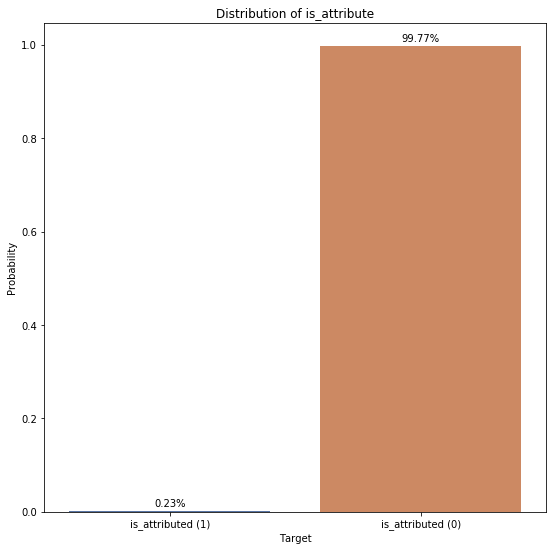

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,9))
mean = (train.is_attributed.values == 1).mean()

ax = sns.barplot(['is_attributed (1)', 'is_attributed (0)'], [mean, 1-mean], palette='deep')
ax.set(xlabel='Target', ylabel='Probability', title='Distribution of is_attribute')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [10]:
# From above graph only 0.23% downloads done and 99.77% not

In [11]:
train = dataPreProcessTime(train)
test = dataPreProcessTime(test)

In [12]:
y = train['is_attributed']
train.drop(['is_attributed', 'attributed_time'], axis=1, inplace=True)

In [13]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id']
test.drop('click_id', axis=1, inplace=True)

In [14]:
print('[{}] Start XGBoost Training'.format(time.time() - start_time))

[147.8688440322876] Start XGBoost Training


In [15]:
# Default parameters in XGBoost
default_model = xgb.XGBClassifier()
default_model.__dict__

{'max_depth': 3,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'silent': True,
 'objective': 'binary:logistic',
 'booster': 'gbtree',
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'missing': nan,
 'kwargs': {},
 '_Booster': None,
 'seed': None,
 'random_state': 0,
 'nthread': None,
 'n_jobs': 1,
 'importance_type': 'gain'}

In [18]:
# Solution_1

# Use XGBoost

params = {'eta': 0.1, 
          'max_depth': 4, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':100,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99, 
          'scale_pos_weight': 150,
          'silent': True}

In [19]:
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)

In [20]:
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

C:\Users\OsamaM2\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [22]:
# The result is based on train_sample.csv data set
model = xgb.train(params, xgb.DMatrix(x1, y1), 270, watchlist, maximize=True, verbose_eval=10)

[0]	train-auc:0.855409	valid-auc:0.85572
[10]	train-auc:0.960147	valid-auc:0.939409
[20]	train-auc:0.969122	valid-auc:0.928932
[30]	train-auc:0.973935	valid-auc:0.929489
[40]	train-auc:0.979374	valid-auc:0.93036
[50]	train-auc:0.983324	valid-auc:0.92588
[60]	train-auc:0.986642	valid-auc:0.928877
[70]	train-auc:0.988638	valid-auc:0.927848
[80]	train-auc:0.990095	valid-auc:0.928712
[90]	train-auc:0.992718	valid-auc:0.927814
[100]	train-auc:0.993798	valid-auc:0.927514
[110]	train-auc:0.994794	valid-auc:0.927539
[120]	train-auc:0.995279	valid-auc:0.927505
[130]	train-auc:0.995584	valid-auc:0.926503
[140]	train-auc:0.995992	valid-auc:0.927806
[150]	train-auc:0.996378	valid-auc:0.927585
[160]	train-auc:0.9966	valid-auc:0.926862
[170]	train-auc:0.9968	valid-auc:0.926958
[180]	train-auc:0.996937	valid-auc:0.927564
[190]	train-auc:0.997144	valid-auc:0.926202
[200]	train-auc:0.997265	valid-auc:0.926595
[210]	train-auc:0.997351	valid-auc:0.927259
[220]	train-auc:0.997449	valid-auc:0.927313
[230]	

In [23]:
print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

[271.1279864311218] Finish XGBoost Training


In [35]:
# Solution_2

from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV

# Set the parameteters for XGBoost
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

model = xgb.XGBClassifier()
cv = GridSearchCV(model, parameters,cv=5, n_jobs=4, scoring='roc_auc')

cv.fit(x1, y1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'learning_rate': [0.05], 'max_depth': [6], 'min_child_weight': [11], 'silent': [1], 'subsample': [0.8], 'colsample_bytree': [0.7], 'n_estimators': [5], 'missing': [-999], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [36]:
print('Best estimator:')
print(cv.best_estimator_)

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=11, missing=-999, n_estimators=5,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=1,
       subsample=0.8)


In [39]:
# The result is based on train_sample.csv data set

score = cv.best_estimator_.predict_proba(x1)
print('Best ROC-AUC: {:.4f}'.format(metrics.roc_auc_score(y1, score[:, 1], average='macro')))

Best ROC-AUC: 0.8173


In [24]:
# add the executable file to show the plot_tree as below image
import os
os.environ["PATH"] += os.pathsep + r"C:\Users\OsamaM2\AppData\Local\Continuum\anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz"

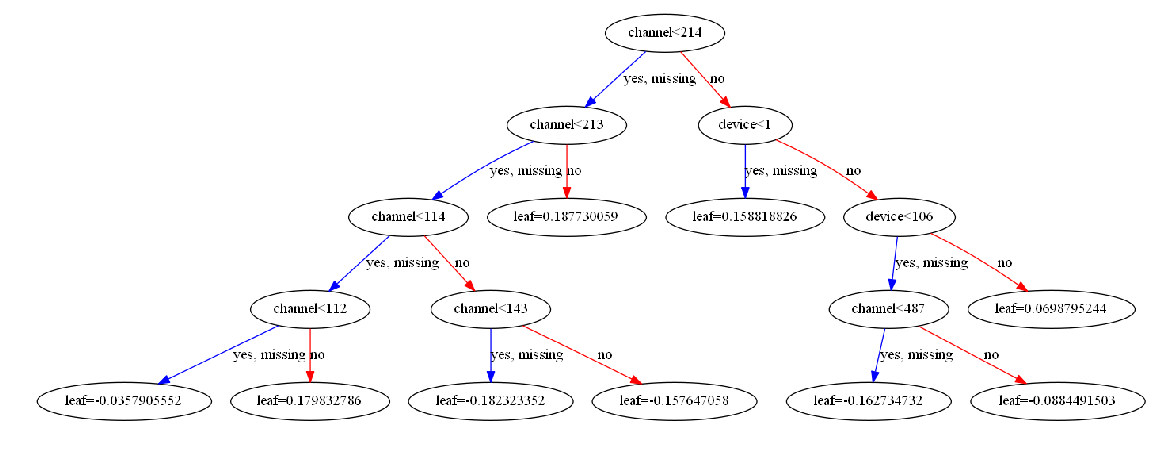

In [32]:
import matplotlib.pyplot as plt

xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

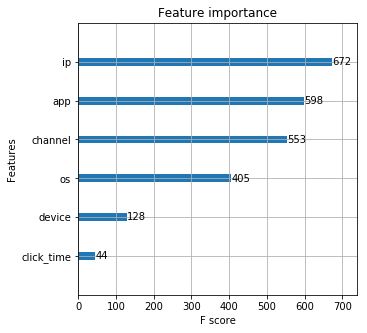

In [28]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
sub['is_attributed'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv',index=False)